In [1]:
# import libraries
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, jaccard_score
import numpy as np
import os

In [2]:
area_one_pixel = (1.27/700)**2

In [12]:
def display_images(image, model_result, ground_truth):
    """
    Display the leaf image, model result, and ground truth side by side.
    
    Parameters:
    image (numpy.ndarray): The original leaf image.
    model_result (numpy.ndarray): The image produced by the model.
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    None
    """

    plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("leaf")

    plt.subplot(1, 3, 2)
    plt.imshow(model_result)
    plt.title("result")

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth)
    plt.title("ground_truth")


def format_ground_truth(ground_truth):
    """
    Format the ground truth image using specific target values.
    
    Parameters:
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    numpy.ndarray: The formatted ground truth image.
    """

    # Define the target values for the ground truth image
    target_values = np.array([63, 127, 191, 255])

    # Define the bins for the ground truth image
    bins = np.array([0, 95, 159, 223, 255])

    # Convert the ground truth image to a 1D array
    indices = np.digitize(ground_truth, bins) - 1

    # Ensure that the indices are within the range of the target values
    valid_indices = np.where(indices < len(target_values), indices, len(target_values) - 1)

    # Create the formatted ground truth image
    ground_truth = target_values[valid_indices]

    # Convert the formatted ground truth image to the original shape
    ground_truth = ground_truth.astype(np.uint8)

    return ground_truth


def format_images(model_result, ground_truth):
    """
    Format the images by converting them to grayscale and flattening them.
    
    Parameters:
    model_result (numpy.ndarray): The image produced by the model.
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    tuple: The formatted model result and ground truth images.
    """

    # Convert images to grayscale
    model_result = cv2.cvtColor(model_result, cv2.COLOR_RGB2GRAY)
    ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_RGB2GRAY)

    # Flatten the images
    model_result = model_result.flatten()
    ground_truth = ground_truth.flatten()

    return model_result, ground_truth


def label_metrics(ground_truth, model_result, class_label):
    """
    Calculate metrics for a specific class.
    
    Parameters:
    ground_truth (numpy.ndarray): The ground truth image.
    model_result (numpy.ndarray): The image produced by the model.
    class_label (int): The label of the class for which to calculate the metrics.

    Returns:
    tuple: The precision, recall, F1 score, and IoU for the class.
    """

    precision = precision_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]
    recall = recall_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]
    f1 = f1_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]
    iou = jaccard_score(ground_truth, model_result, labels=[class_label], average=None)[0]

    # Calculate the surface error
    ground_truth_surface = np.sum(ground_truth == class_label)
    model_result_surface = np.sum(model_result == class_label)
    surface_error_pixels = abs(ground_truth_surface - model_result_surface)

    ground_truth_surface_cm2 = ground_truth_surface * area_one_pixel
    model_result_surface_cm2 = model_result_surface * area_one_pixel
    surface_error_cm2 = abs(ground_truth_surface_cm2 - model_result_surface_cm2)


    surface_error_percent = (abs(ground_truth_surface - model_result_surface) / ground_truth_surface)*100 if ground_truth_surface > 0 else 0

    return precision, recall, f1, iou, ground_truth_surface_cm2, model_result_surface_cm2 ,surface_error_cm2, surface_error_percent


def global_metrics(ground_truth, result):
    """
    Calculate the global metrics.
    
    Parameters:
    ground_truth (numpy.ndarray): The ground truth image.
    result (numpy.ndarray): The image produced by the model.

    Returns:
    tuple: The mean average precision (mAP) and accuracy.
    """

    mAP = precision_score(ground_truth, result, average='macro', zero_division=1)
    accuracy = accuracy_score(ground_truth, result)

    return mAP, accuracy


def process_images_and_calculate_metrics(image, model_result, ground_truth):
    """
    Process the images and calculate the metrics.
    
    Parameters:
    image (numpy.ndarray): The original leaf image.
    model_result (numpy.ndarray): The image produced by the model.
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    None
    """

    # Format the images
    model_result_reshaped = format_ground_truth(model_result)
    ground_truth_reshaped = format_ground_truth(ground_truth)

    model_result, ground_truth = format_images(model_result, ground_truth)

    # Calculate the metrics for each class
    code = {'BACKGROUND':255 ,'LEAF':191, 'RUST':63, 'OIDIUM':127}

    for class_name, class_label in code.items():
        precision, recall, f1, IoU, ground_truth_surface_cm2, model_result_surface_cm2,surface_error_cm2, surface_error_percent = label_metrics(ground_truth, model_result, class_label=class_label)
        print(f"Class: {class_name}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-score: {f1:.3f}")
        print(f"IoU: {IoU:.3f}")
        print(f"Ground truth surface : {ground_truth_surface_cm2:.3f} cm2")
        print(f"Model result surface : {model_result_surface_cm2:.3f} cm2")
        print(f"Surface error : {surface_error_cm2:.3f} cm2")
        print(f"Area error : {surface_error_percent:.3f} %")
        print("\n")

    # Calculate the global metrics
    mAP, accuracy = global_metrics(ground_truth, model_result)
    print(f"mAP: {mAP}")
    print(f"Accuracy: {accuracy}")

    # Reshape the images to the original shape for display
    model_result.reshape((image.shape[1], image.shape[0], 1))
    ground_truth.reshape((image.shape[1], image.shape[0], 1))

    # Display the images
    display_images(image, model_result_reshaped, ground_truth_reshaped)

Class: BACKGROUND
Precision: 0.983
Recall: 0.993
F1-score: 0.988
IoU: 0.977
Ground truth surface : 12.965 cm2
Model result surface : 13.091 cm2
Surface error : 0.126 cm2
Area error : 0.971 %


Class: LEAF
Precision: 0.974
Recall: 0.912
F1-score: 0.942
IoU: 0.891
Ground truth surface : 19.228 cm2
Model result surface : 18.007 cm2
Surface error : 1.220 cm2
Area error : 6.347 %


Class: RUST
Precision: 0.654
Recall: 0.963
F1-score: 0.779
IoU: 0.638
Ground truth surface : 3.763 cm2
Model result surface : 5.546 cm2
Surface error : 1.783 cm2
Area error : 47.383 %


Class: OIDIUM
Precision: 0.233
Recall: 0.424
F1-score: 0.300
IoU: 0.177
Ground truth surface : 0.031 cm2
Model result surface : 0.057 cm2
Surface error : 0.026 cm2
Area error : 82.027 %


mAP: 0.9789824366719023
Accuracy: 0.9279013906039344


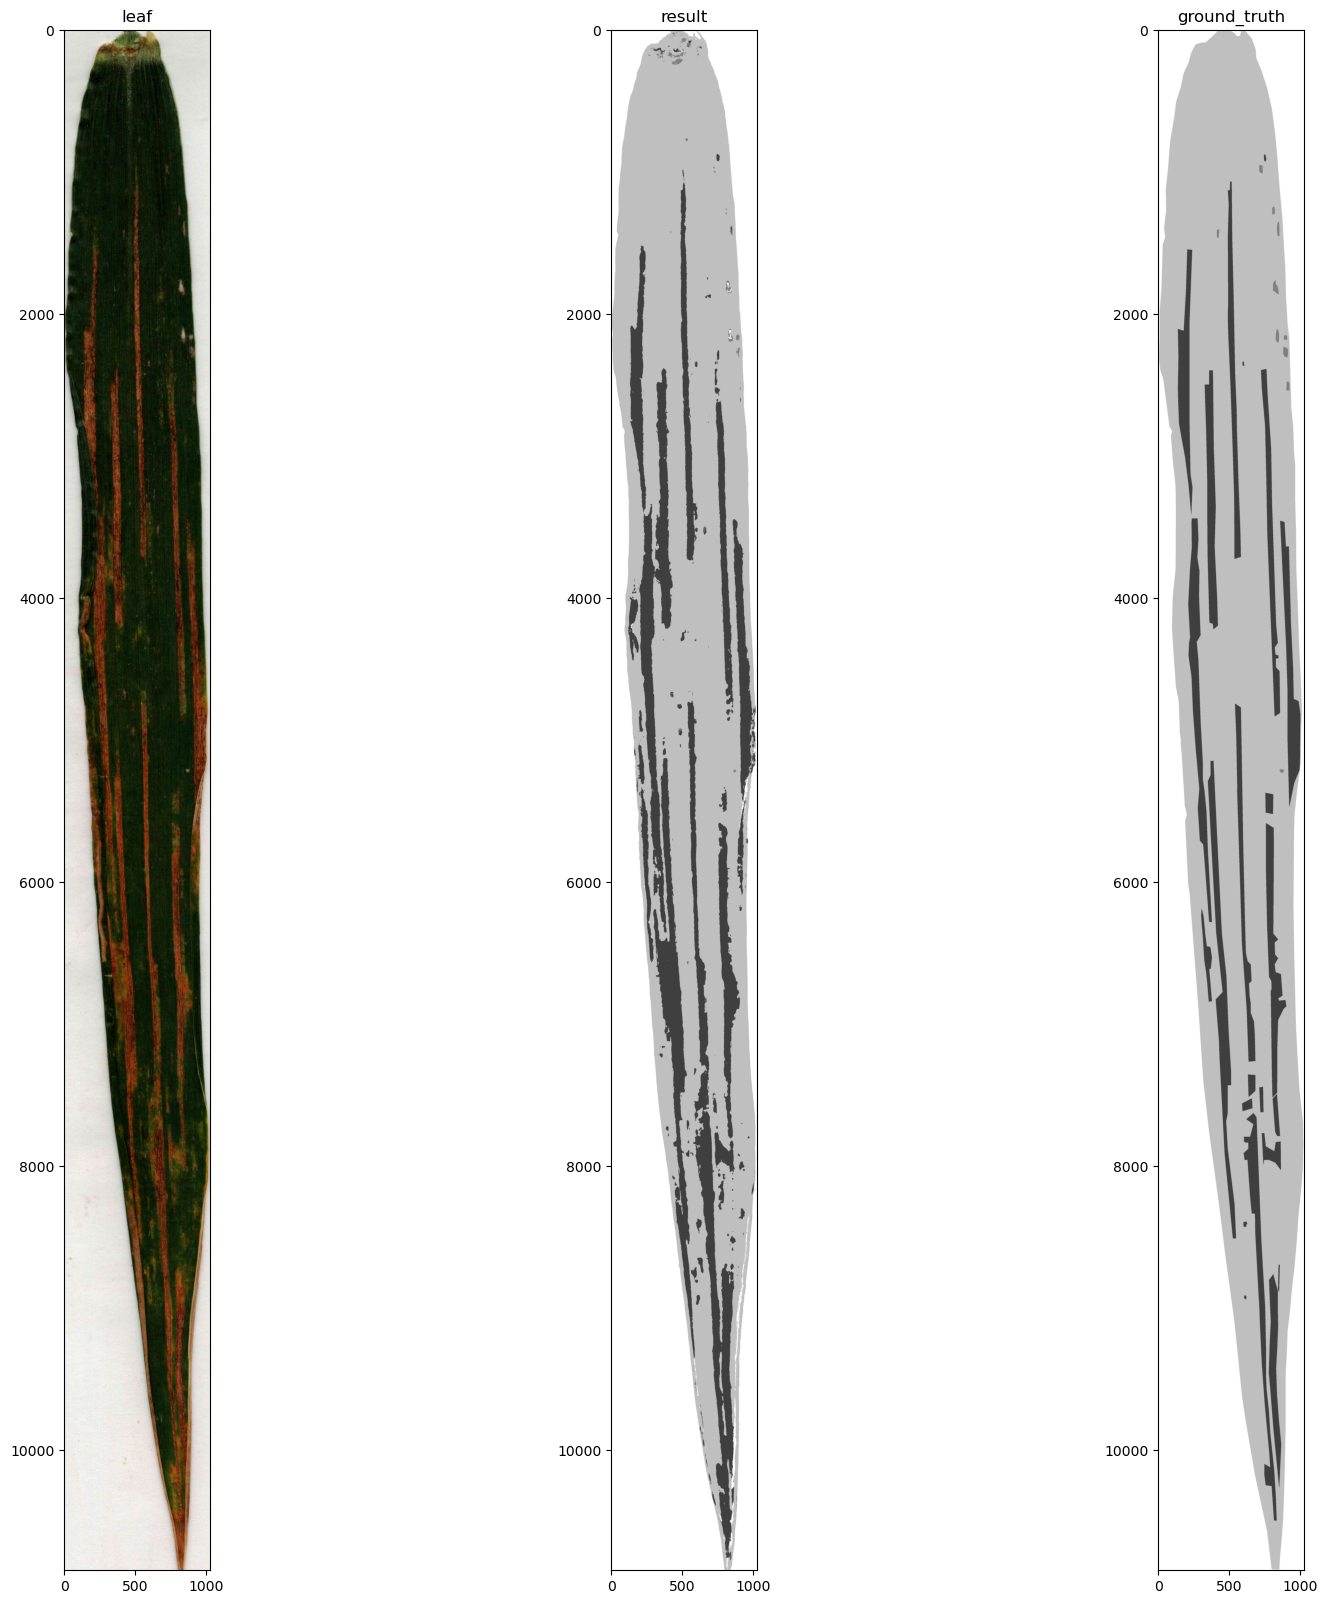

In [13]:
image_path = "test_images/672_leaf2.jpg"

# Get the name of the file without the extension
base_name = os.path.basename(image_path)
file_name, extension = os.path.splitext(base_name)


# Define the paths to the model result and ground truth images
model_result_path = os.path.join("model_predictions/", f"{file_name}_Simple_Segmentation.png")
ground_truth_path = os.path.join("ground_truth/", f"{file_name}_ground_truth{extension}")

# Load the images
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

model_result = cv2.imread(model_result_path)
model_result = cv2.cvtColor(model_result, cv2.COLOR_BGR2RGB)

ground_truth = cv2.imread(ground_truth_path)
ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB)

# Process the images and calculate the metrics
process_images_and_calculate_metrics(image, model_result, ground_truth)